# Setup

In [1]:
# handle math and data
import numpy as np
import pandas as pd
import time
import math

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import sys
import joblib

# random states
SEED = 69

# deep learning
import tensorflow as tf
from tensorflow import keras

K = keras.backend

def reset_backend():
    K.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

## Find LR Classes

In [56]:
def round_up_to_tenth(n):
    a = np.log(n) / np.log(10)
    a_ = np.rint(a)
    return 10**a_

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-10, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses, max_loss=None):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    
    tick = round_up_to_tenth(min(rates))
    x_ticks = []
    while tick < max(rates)*10:
        x_ticks.append(tick)
        tick = tick * 10
    plt.gca().set_xticks(x_ticks)
    
    plt.hlines(min(losses), min(rates), max(rates))
    if max_loss is None:
        plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    else:
        plt.axis([min(rates), max(rates), min(losses), max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

# Get Data

In [5]:
from tensorflow.keras.datasets import fashion_mnist

# 60K train and 10K test samples, shape (28, 28), type 'uint8'
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

val_size = 5000
X_train, X_val = X_train_full[val_size:], X_train_full[:val_size]
y_train, y_val = y_train_full[val_size:], y_train_full[:val_size]

## Visualize Data

In [13]:
def plot_image(image):    
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()

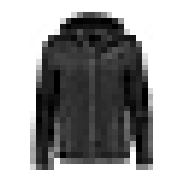

In [14]:
plot_image(X_train[0])

In [16]:
attribute_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", 
                   "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

attribute_names[y_train[0]]

'Coat'

In [17]:
def plot_images(X, y, n_rows=4, n_cols=10):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(attribute_names[y[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

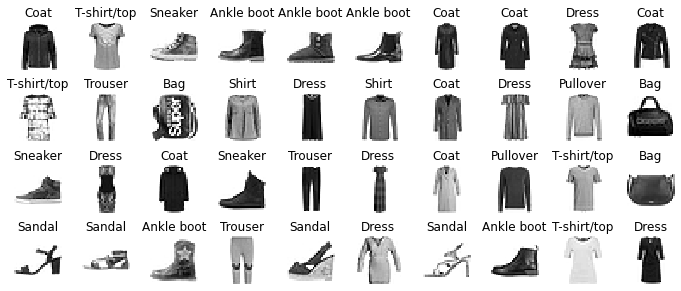

In [18]:
plot_images(X_train, y_train)

# Custom Layer Normalization

The goal is to create a custom layer that does the same thing as `keras.layers.LayerNormalization`.
- **[LayerNormalization](https://keras.io/api/layers/normalization_layers/layer_normalization/)**

In [49]:
sample_inputs = X_train[:100]

layer_norm = tf.keras.layers.LayerNormalization(axis=1)

sample_outputs = layer_norm(sample_inputs)
sample_inputs.shape, sample_outputs.shape

((100, 28, 28), TensorShape([100, 28, 28]))

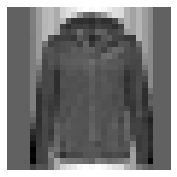

In [50]:
plot_image(sample_outputs[0].numpy())

## Custom Layer

We subclass `tf.keras.layers.Layer`
- **[Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)**

In [51]:
class CustomLayerNormalization(keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
        
    def build(self, input_shape):
        self.a = self.add_weight(shape=input_shape[self.axis],
                                 initializer="ones",
                                 dtype=tf.float32,
                                 trainable=True)
        self.b = self.add_weight(shape=input_shape[self.axis],
                                 initializer="zeros", 
                                 dtype=tf.float32,
                                 trainable=True)
    
    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        mean, variance = tf.nn.moments(inputs, axes=self.axis, keepdims=True)
        std = tf.math.sqrt(variance)
        eps = 1e-7
        
        return (self.a * (inputs - mean) / (std + eps)) + self.b
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "axis": self.axis}

In [52]:
custom_layer_norm = CustomLayerNormalization(axis=1)

custom_sample_outputs = custom_layer_norm(sample_inputs)
sample_inputs.shape, custom_sample_outputs.shape

((100, 28, 28), TensorShape([100, 28, 28]))

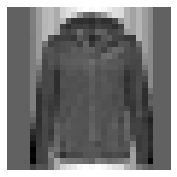

In [53]:
plot_image(custom_sample_outputs[0].numpy())

Good, they do the same thing.

# Custom Training Loop

Now we want to create our own custom training loop that:
- Displays epoch, iteration, mean training loss, and mean accuracy per epoch
    - Updates at every iteration
    - Validation loss and accuracy at end of each epoch
- Use a different optimizer and lr for first two hidden layers and another one for last two hidden layers

## Normal Model

Let's first train a normal model for comparison.

In [65]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam

reset_backend()

# create model
model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
for _ in range(4):
    model.add(Dense(300, activation="elu", 
                    kernel_initializer="he_normal"))
model.add(Dense(10, activation="softmax"))

# compile model
optimizer = Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

### Optimal LR

In [66]:
epochs = 1
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train,
                                   epochs=epochs, batch_size=batch_size,
                                   min_rate=1e-8, max_rate=10)

430/430 [==============================] - 4s 7ms/step - loss: 1308199256850432.0000 - accuracy: 0.2381


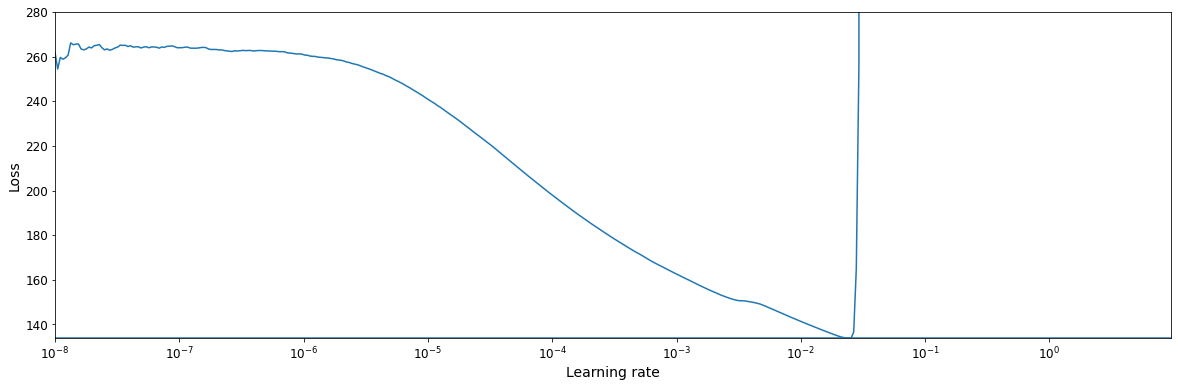

In [68]:
plt.figure(figsize=(20,6))
plot_lr_vs_loss(rates, losses, max_loss=280)

A decent lr should be `5e-4`.

In [77]:
lr = 5e-4

### Train Model

In [83]:
reset_backend()

# create model
model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
for _ in range(4):
    model.add(Dense(300, activation="elu", 
                    kernel_initializer="he_normal"))
model.add(Dense(10, activation="softmax"))

# compile model
optimizer = Nadam(learning_rate=lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

**Callbacks**

In [87]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [early_stopping_cb]

**Train**

In [88]:
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=[X_val, y_val],
                    callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2370 - accuracy: 0.9118 - val_loss: 0.3533 - val_accuracy: 0.8822
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2331 - accuracy: 0.9125 - val_loss: 0.3487 - val_accuracy: 0.8970
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2361 - accuracy: 0.9111 - val_loss: 0.3772 - val_accuracy: 0.8806
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2305 - accuracy: 0.9140 - val_loss: 0.3757 - val_accuracy: 0.8860
Epoch 5/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2205 - accuracy: 0.9168 - val_loss: 0.3958 - val_accuracy: 0.8926
Epoch 6/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2210 - accuracy: 0.9176 - val_loss: 0.4194 - val_accuracy: 0.8752
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2160 - accuracy: 0.9200 - val_loss: 0.4068 - val_

<AxesSubplot:>

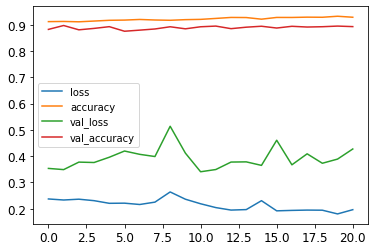

In [91]:
pd.DataFrame(history.history).plot()

### Evaluate

In [92]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8881


[0.3858397305011749, 0.8881000280380249]

`88.8%` accuracy

## Custom Model

In [126]:
reset_backend()

# create model
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [127]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

**Hyperparams**

In [128]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

### Custom Loop

In [129]:
from tqdm.notebook import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_val)
            status["val_loss"] = np.mean(loss_fn(y_val, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_val, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]